In this notebook, we will build an abstractive based text summarizer using deep learning from the scratch in python using keras

I recommend you to go through the article over [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/) to cover all the concepts which is required to build our own summarizer

# Understanding the Problem Statement

Customer reviews can often be long and descriptive. Analyzing these reviews manually, as you can imagine, is really time-consuming. This is where the brilliance of Natural Language Processing can be applied to generate a summary for long reviews.

We will be working on a really cool dataset. Our objective here is to generate a summary for the Amazon Fine Food reviews using the abstraction-based approach we learned about above. You can download the dataset from[ here ](https://www.kaggle.com/snap/amazon-fine-food-reviews)

It’s time to fire up our Jupyter notebooks! Let’s dive into the implementation details right away.

# Custom Attention Layer

Keras does not officially support attention layer. So, we can either implement our own attention layer or use a third-party implementation. We will go with the latter option for this article. You can download the attention layer from [here](https://github.com/thushv89/attention_keras/blob/master/layers/attention.py) and copy it in a different file called attention.py.

Let’s import it into our environment:

# Import the Libraries

In [37]:
import numpy as np
import pandas as pd

import re
import warnings
import nltk
import datetime
import math

from IPython.display import clear_output

from bs4 import BeautifulSoup

from nltk.corpus import stopwords

from matplotlib import pyplot

from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Attention, Bidirectional, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [38]:
date_now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [39]:
b_train = False

In [40]:
# Print iterations progress
def printProgressBar (iteration, total, suffix = 'Complete', decimals = 1, length = 20, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r> {iteration}/{total} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total:
        clear_output(wait=True)
        print()

# Read the dataset

This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012. These reviews include product and user information, ratings, plain text review, and summary. It also includes reviews from all other Amazon categories.

We’ll take a sample of 100,000 reviews to reduce the training time of our model. Feel free to use the entire dataset for training your model if your machine has that kind of computational power.

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
url="/content/drive/MyDrive/Colab Notebooks/Reviews.csv"
data=pd.read_csv(url,nrows=100000)
# data=pd.read_csv(url)

# Drop Duplicates and NA values

In [43]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

# Information about dataset

Let us look at datatypes and shape of the dataset

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88421 non-null  int64 
 1   ProductId               88421 non-null  object
 2   UserId                  88421 non-null  object
 3   ProfileName             88421 non-null  object
 4   HelpfulnessNumerator    88421 non-null  int64 
 5   HelpfulnessDenominator  88421 non-null  int64 
 6   Score                   88421 non-null  int64 
 7   Time                    88421 non-null  int64 
 8   Summary                 88421 non-null  object
 9   Text                    88421 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


In [45]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


# Preprocessing

Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

Here is the dictionary that we will use for expanding the contractions:

In [46]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below preprocessing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove short words

Let’s define the function:

In [47]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
# call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

Let us look at the first five preprocessed reviews

In [49]:
cleaned_text[:5]  

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [50]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

Let us look at the first 10 preprocessed summaries

In [51]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [52]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

# Drop empty rows

In [53]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

# Understanding the distribution of the sequences

Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

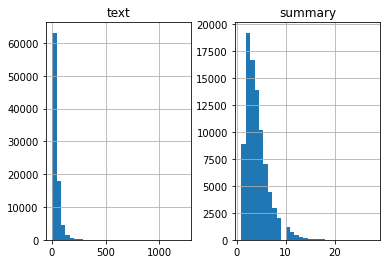

In [54]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

Interesting. We can fix the maximum length of the summary to 8 since that seems to be the majority summary length.

Let us understand the proportion of the length of summaries below 8

In [55]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9424907471335922


We observe that 94% of the summaries have length below 8. So, we can fix maximum length of summary to 8.

Let us fix the maximum length of review to 30

In [56]:
max_text_len=30
# max_summary_len = 8
max_summary_len = 10

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [57]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])
cleaned_score = np.array(data['Score'])

short_text=[]
short_summary=[]
short_score=[]

for i in range(len(cleaned_text)):
#    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
    if(len(cleaned_summary[i].split())<=max_summary_len-2 and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        short_score.append(cleaned_score[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary,'score':short_score})
df=pd.get_dummies(df, columns = ['score'])

In [58]:
df.head()

,text,summary,score_1,score_2,score_3,score_4,score_5
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food,0,0,0,0,1
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised,1,0,0,0,0
2,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine,0,1,0,0,0
3,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy,0,0,0,0,1
4,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,great just as good as the expensive brands,0,0,0,0,1


Remember to add the **START** and **END** special tokens at the beginning and end of the summary. Here, I have chosen **sostok** and **eostok** as START and END tokens

**Note:** Be sure that the chosen special tokens never appear in the summary

In [59]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [60]:
df.head()

,text,summary,score_1,score_2,score_3,score_4,score_5
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostok good quality dog food eostok,0,0,0,0,1
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,sostok not as advertised eostok,1,0,0,0,0
2,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,sostok cough medicine eostok,0,1,0,0,0
3,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,sostok great taffy eostok,0,0,0,0,1
4,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,sostok great just as good as the expensive brands eostok,0,0,0,0,1


We are getting closer to the model building part. Before that, we need to split our dataset into a training and validation set. We’ll use 90% of the dataset as the training data and evaluate the performance on the remaining 10% (holdout set):

In [61]:
x_tr, x_test, y_tr, y_test =train_test_split(np.array(df['text']),np.array(df['summary']),test_size=.2,random_state=0,shuffle=True) 
x_tr, x_val, y_tr, y_val =train_test_split(x_tr,y_tr,test_size=.2,random_state=0,shuffle=True) 

# Preparing the Tokenizer

A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. Go ahead and build tokenizers for text and summary:

## Text Tokenizer

In [62]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

### Rarewords and its Coverage

Let us look at the proportion rare words and its total coverage in the entire text

Here, I am defining the threshold to be 4 which means word whose count is below 4 is considered as a rare word

In [63]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.24258248279136
Total Coverage of rare words: 3.5447832609381185


**Remember**:


* **tot_cnt** gives the size of vocabulary (which means every unique words in the text)
 
*   **cnt** gives me the no. of rare words whose count falls below threshold

*  **tot_cnt - cnt** gives me the top most common words 

Let us define the tokenizer with top most common words for reviews.

In [64]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)
x_test_seq = x_tokenizer.texts_to_sequences(x_test)

#padding zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')
x_test = pad_sequences(x_test_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [65]:
x_voc

7112

## Summary Tokenizer

In [66]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

### Rarewords and its Coverage

Let us look at the proportion rare words and its total coverage in the entire summary

Here, I am defining the threshold to be 6 which means word whose count is below 6 is considered as a rare word

In [67]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 78.97415818324197
Total Coverage of rare words: 6.4096809068895535


Let us define the tokenizer with top most common words for summary.

In [68]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 
y_test_seq = y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')
y_test = pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc = y_tokenizer.num_words +1 # +1 per il padding 0!

Let us check whether word count of start token is equal to length of the training data

In [69]:
y_tokenizer.word_counts['sostok'],len(y_tr)   

(30188, 30188)

Here, I am deleting the rows that contain only **START** and **END** tokens

In [70]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [71]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val = np.delete(y_val,ind, axis=0)
x_val = np.delete(x_val,ind, axis=0)

In [72]:
ind=[]
for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test = np.delete(y_test,ind, axis=0)
x_test = np.delete(x_test,ind, axis=0)

# Model building

We are finally at the model building part. But before we do that, we need to familiarize ourselves with a few terms which are required prior to building the model.

**Return Sequences = True**: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

**Return State = True**: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

**Initial State**: This is used to initialize the internal states of the LSTM for the first timestep

**Stacked LSTM**: Stacked LSTM has multiple layers of LSTM stacked on top of each other. 
This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)

Here, we are building a 3 stacked LSTM for the encoder:

## Attention Layer

In [73]:
# Attention layer

import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

## LSTM Model


### Defining the training model

Here we're defining the LSTM model we'll use to train all the needed layers. After the training we'll separate them to get a proper encoder and a proper decoder we'll able to use to make new summmaries.

In [ ]:
from tensorflow.keras import backend as K 
# from attention import AttentionLayer

K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,
                     dropout=0.4,recurrent_dropout=0.4)

encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,
                     dropout=0.4,recurrent_dropout=0.4)

encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True,
                     dropout=0.4,recurrent_dropout=0.4)

encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,
                    dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

# Compile the model using Adam as the optimizer and 
# sparse categorical crossentropy as the loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Let's stop the training as soon as it hits a minimum
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

# Tensorboard will let us see the logs 
log_dir = "logs/fit/" + date_now
tb = TensorBoard(log_dir=log_dir, histogram_freq=1)

# We’ll train the model on a batch size of 128 and validate it on the 
# holdout set (which is 10% of our dataset):
is_model_lstm_trained = True

if not is_model_lstm_trained:
    history=model.fit([x_tr,y_tr[:,:-1]], 
                      y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                      epochs=50,
                      callbacks=[es,tb],
                      batch_size=128, 
                      validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

### LSTM Encoder - Decoder Model

In [142]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

### Save or Load the weights

In [ ]:
if not is_model_lstm_trained:
    model_lstm.save_weights("./saved_models/summary_net_lstm/ckpt")
else:
    model_lstm.load_weights("./saved_models/summary_net_lstm/ckpt")

## GRU Model



### Defining the training model

Here we're defining the GRU model we'll use to train all the needed layers. After the training we'll separate them to get a proper encoder and a proper decoder we'll able to use to make new summmaries.

In [74]:
from tensorflow.keras import backend as K 

K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_gru1 = GRU(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_1 = encoder_gru1(enc_emb)

#encoder lstm 2
encoder_gru2 = GRU(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_2 = encoder_gru2(encoder_output1)

#encoder lstm 3
encoder_gru3 = GRU(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state = encoder_gru3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_state = decoder_gru(dec_emb,initial_state=state)

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model_gru = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model_gru.summary() 

# Compile the model using Adam as the optimizer and 
# sparse categorical crossentropy as the loss function
model_gru.compile(optimizer='adam', loss='sparse_categorical_crossentropy')


# Train the model if it's not already trained
is_model_gru_trained = True

if not is_model_gru_trained:
    history=model_gru.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es,tb],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      711200      input_1[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       [(None, 30, 300), (N 361800      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### GRU Encoder - Decoder Model

In [76]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_2 = decoder_gru(dec_emb2, initial_state=[decoder_state_input])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input],
    [decoder_outputs2] + [state_2])

### Save or Load the Weights

In [ ]:
if not is_model_gru_trained:
    model_gru.save_weights("./saved_models/summary_net_gru/ckpt")
else:
    model_gru.load_weights("./saved_models/summary_net_gru/ckpt")

## Bidirectional GRU Model

In [ ]:
from tensorflow.keras import backend as K 

K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_gru1 = Bidirectional(GRU(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4))
encoder_output1, state_1, _ = encoder_gru1(enc_emb)

#encoder lstm 2
encoder_gru2 = Bidirectional(GRU(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4))
encoder_output2, state_2, _ = encoder_gru2(encoder_output1)

#encoder lstm 3
encoder_gru3 = Bidirectional(GRU(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4))
encoder_outputs, state_3, _ = encoder_gru3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2))
decoder_outputs,decoder_state, _ = decoder_gru(dec_emb, initial_state=[state_3, state_3])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model_bi = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model_bi.summary() 

model_bi.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

log_dir = "logs/fit/" + date_now
tb = TensorBoard(log_dir=log_dir, histogram_freq=1)

is_model_bi_trained = False

if not is_model_bi_trained:
    history = model_bi.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es,tb],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

### Bidirectional GRU Encoder - Decoder Model

In [ ]:
# TODO - Sorry

### Save or Load the weights

In [ ]:
if not is_model_bi_trained:
    model_bi.save_weights("./saved_models/summary_net_bi/ckpt")
else:
    model_bi.load_weights("./saved_models/summary_net_bi/ckpt")

# Understanding the Diagnostic plot

Now, we will plot a few diagnostic plots to understand the behavior of the model over time:

In [ ]:
if b_train:
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

From the plot, we can infer that validation loss has increased after epoch 17 for 2 successive epochs. Hence, training is stopped at epoch 19.

Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Inference

Set up the inference for the encoder and decoder:

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

We are defining a function below which is the implementation of the inference process (which we covered [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)):

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Here are a few summaries generated by the model:

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(x_test[i]))
    print("Original summary:",seq2summary(y_test[i]))
    print("Predicted summary - LSTM model:", decode_sequence(x_test[i].reshape(1,max_text_len)))
    print("Predicted summary - GRU  model:", decode_sequence(x_test[i].reshape(1,max_text_len)))
    print("Predicted summary - Bi   model:", decode_sequence(x_test[i].reshape(1,max_text_len)))

    print("\n")

In [ ]:
verbose = True
predicted_list = []

dimension = x_test.shape[0]

for i in range(dimension):
    predicted_list.append(decode_sequence(x_test[i].reshape(1,max_text_len)))
    if i%1==0 and verbose:
        clear_output(wait=True)
        print("> {0} / {1} \t {2:.2f}%".format(i+1, dimension, (i+1/dimension)*100))

# Sentiment Analysis
Now we want to evaluate the performances of this model.

## Split

In [ ]:
y_classes=['score_1','score_2','score_3','score_4','score_5',]
y = df[y_classes].values

X = df['summary']
Z = df['text']

In [ ]:
# x = the summaries
# y = the scores
# z = the texts

x_tr_sent, x_test_sent, y_tr_sent, y_test_sent, _ , z_test = train_test_split(np.array(X),np.array(y),np.array(Z),test_size=.2,random_state=0,shuffle=True)

x_tr_sent, x_val_sent, y_tr_sent, y_val_sent = train_test_split(x_tr_sent,y_tr_sent,test_size=0.2,random_state=0,shuffle=True)

## Tokenizer

### Summary Tokenizer

In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer_sent = Tokenizer() 
x_tokenizer_sent.fit_on_texts(list(x_tr_sent))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer_sent.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 71.53484729835552
Total Coverage of rare words: 4.825279609526639


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer_sent = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer_sent.fit_on_texts(list(x_tr_sent))

#convert text sequences into integer sequences
x_tr_seq = x_tokenizer_sent.texts_to_sequences(x_tr_sent) 
x_val_seq = x_tokenizer_sent.texts_to_sequences(x_val_sent)
x_test_seq = x_tokenizer_sent.texts_to_sequences(x_test_sent)

#padding zero upto maximum length
x_tr_sent = pad_sequences(x_tr_seq,  maxlen=max_summary_len, padding='post')
x_val_sent = pad_sequences(x_val_seq, maxlen=max_summary_len, padding='post')
x_test_sent = pad_sequences(x_test_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc_sent = x_tokenizer_sent.num_words + 1

In [ ]:
x_voc_sent

2182

### Text Tokenizer

In [ ]:
#prepare a tokenizer for reviews on training data
z_tokenizer = Tokenizer() 
z_tokenizer.fit_on_texts(list(z_test))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in z_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 67.49107809776746
Total Coverage of rare words: 6.675728653769865


In [ ]:
#prepare a tokenizer for reviews on training data
z_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
z_tokenizer.fit_on_texts(list(z_test))

#convert text sequences into integer sequences
z_test_seq = z_tokenizer.texts_to_sequences(z_test)

#padding zero upto maximum length
z_test = pad_sequences(z_test_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
z_voc   =  z_tokenizer.num_words + 1

In [ ]:
z_voc

3918

## Modello

In [ ]:
rating_model = Sequential([
    Embedding(x_voc_sent, 64, trainable=True, mask_zero=True),
    Bidirectional(LSTM(64,  return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='elu'),
    Dropout(0.5),
    Dense(5, activation='sigmoid')
    ])

earlystop = EarlyStopping(monitor = 'val_loss', mode='min', verbose=1,patience=2)

rating_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

rating_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          139648    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 251,397
Trainable params: 251,397
Non-trainable params: 0
__________________________________________________

In [ ]:
# Prova di un altro modello. Per funzionare necessita di cambiare le dimensioni del fit in [:,:] invece di [:,:-1]
'''
from tensorflow.keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate

inp = Input(shape=(max_summary_len,))
emb = Embedding(x_voc_sent, 64, trainable=True, mask_zero=True)(inp)
bid1 = Bidirectional(LSTM(64,  return_sequences=True))(emb)
bid2 = Bidirectional(LSTM(40, return_sequences=True))(bid1)
avg_pool = GlobalAveragePooling1D()(bid2)
max_pool = GlobalMaxPooling1D()(bid2)
conc = concatenate([avg_pool, max_pool])
outp = Dense(5, activation='sigmoid')(conc)

rating_model = Model(inputs=inp, outputs=outp)

earlystop = EarlyStopping(monitor = 'val_loss', mode='min', verbose=1,patience=2)

rating_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

rating_model.summary()
'''

"\nfrom tensorflow.keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate\n\ninp = Input(shape=(max_summary_len,))\nemb = Embedding(x_voc_sent, 64, trainable=True, mask_zero=True)(inp)\nbid1 = Bidirectional(LSTM(64,  return_sequences=True))(emb)\nbid2 = Bidirectional(LSTM(40, return_sequences=True))(bid1)\navg_pool = GlobalAveragePooling1D()(bid2)\nmax_pool = GlobalMaxPooling1D()(bid2)\nconc = concatenate([avg_pool, max_pool])\noutp = Dense(5, activation='sigmoid')(conc)\n\nrating_model = Model(inputs=inp, outputs=outp)\n\nearlystop = EarlyStopping(monitor = 'val_loss', mode='min', verbose=1,patience=2)\n\nrating_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])\n\nrating_model.summary()\n"

## Train

In [ ]:
#[:,:-1]
if b_train:
    rating_model.fit(x_tr_sent[:,1:-1], y_tr_sent, batch_size=128, validation_data=(x_val_sent[:,1:-1], y_val_sent), epochs = 25, callbacks=[earlystop])

## Salvataggio

In [ ]:
if b_train:
    rating_model.save_weights("./saved_models/rating_net/ckpt")
else:
    rating_model.load_weights("./saved_models/rating_net/ckpt")

## Test
Valutiamo il modello del sentiment appena creato.

In [ ]:
x_test_sent_resh = x_test_sent
for i in range(x_test_sent.shape[0]):
    x_test_sent_resh[i].reshape(1,max_summary_len)

In [ ]:
predictions = rating_model.predict(x_test_sent_resh[:,1:-1], verbose=1)

295/295 [==============================] - 1s 4ms/step


In [ ]:
test_scores = y_test_sent.argmax(axis=1)
test_predicted_scores = predictions.argmax(axis=1)

In [ ]:
unique, counts = np.unique(test_scores, return_counts=True)
dict_real = dict(zip(unique, counts))

unique, counts = np.unique(test_predicted_scores, return_counts=True)
dict_pred = dict(zip(unique, counts))

print('Valori reali:', dict_real)
print('Valori predetti:', dict_pred)

Valori reali: {0: 806, 1: 468, 2: 591, 3: 1199, 4: 6370}
Valori predetti: {0: 1069, 1: 17, 2: 516, 3: 294, 4: 7538}


In [ ]:
# confusion matrix
print('Test Confusion Matrix:')
x_confusion_matrix = confusion_matrix(test_scores, test_predicted_scores)
print(x_confusion_matrix)

Test Confusion Matrix:
[[ 516    3   59    6  222]
 [ 241    9   82    5  131]
 [ 127    5  177   35  247]
 [  59    0   98  136  906]
 [ 126    0  100  112 6032]]


Tramite la confusion matrix possiamo calcolarci alcuni diversi indici:

* Accuracy $\frac{TP+TN}{TP+FP+TN+FN}$ che rappresenta la percentuale di classificazioni corrette;
* Precision $\frac{TP}{TP+FP}$ che rappresenta la percentuale di classificazioni positive che sono corrette;
* Recall $\frac{TP}{TP+FN}$ che rappresenta la percentuale di elementi positivi che sono stati classificati come positivi
* F1 score $2\cdot\frac{Precision \cdot Recall}{Precision + Recall}$ che rappresenta la media pesata della precisione e della recall.


In [ ]:
# classification_report
class_rep = classification_report(test_scores, test_predicted_scores)
print(class_rep)

              precision    recall  f1-score   support

           0       0.48      0.64      0.55       806
           1       0.53      0.02      0.04       468
           2       0.34      0.30      0.32       591
           3       0.46      0.11      0.18      1199
           4       0.80      0.95      0.87      6370

    accuracy                           0.73      9434
   macro avg       0.52      0.40      0.39      9434
weighted avg       0.69      0.73      0.68      9434



# Valutazione modello del summary generator
L'idea su cui si basa la seguente valutazione è che il testo originale e la sua summary dovrebbero generare lo stesso valore di rating. Somministriamo al modello per predirre i rating le summary generate e le confrontiamo con le label per valutarne la correttezza.

Dal momento che anche il modello per la predizione dei rating non è totalmente affidabile, successivamente ci avvarremmo anche del calcolo del BLEU score per poter esprimere su giudizio più corretto.

In [ ]:
verbose = True
z_predicted_list = []

dimension = z_test.shape[0]

for i in range(dimension):
    z_predicted_list.append(decode_sequence(z_test[i].reshape(1,max_text_len)))
    if i%1==0 and verbose:
        clear_output(wait=True)
        print("> {0} / {1} \t {2:.2f}%".format(i+1, dimension, (i+1/dimension)*100))


> 9433 / 9434 	 99.99%


In [ ]:
# possiamo utilizzare x_tokenizer_sent in quanto quello che abbiamo generato tramite la predizione è un summary e x_tokenizer_sent si occupa di tokenizzare proprio i summary.
z_predicted_list_seq = x_tokenizer_sent.texts_to_sequences(z_predicted_list)
z_predicted_list = pad_sequences(z_predicted_list_seq, maxlen=max_summary_len, padding='post')

In [ ]:
z_predicted_list_resh = z_predicted_list
for i in range(z_predicted_list.shape[0]):
    z_predicted_list_resh[i].reshape(1,max_summary_len)

In [ ]:
z_predictions = rating_model.predict(z_predicted_list_resh[:,1:-1], verbose=1)

295/295 [==============================] - 1s 4ms/step


In [ ]:
test_scores = y_test_sent.argmax(axis=1)
z_test_predicted_scores = z_predictions.argmax(axis=1)

In [ ]:
unique, counts = np.unique(test_scores, return_counts=True)
dict_real = dict(zip(unique, counts))

unique, counts = np.unique(test_predicted_scores, return_counts=True)
dict_pred = dict(zip(unique, counts))

print('Valori reali:', dict_real)
print('Valori predetti:', dict_pred)

Valori reali: {0: 806, 1: 468, 2: 591, 3: 1199, 4: 6370}
Valori predetti: {0: 1069, 1: 17, 2: 516, 3: 294, 4: 7538}


In [ ]:
# confusion matrix
print('Predicted Summary Ratings Confusion Matrix :')
z_confusion_matrix = confusion_matrix(test_scores, z_test_predicted_scores)
print(z_confusion_matrix)

Predicted Summary Ratings Confusion Matrix :
[[ 115    0   74    1  616]
 [  65    0   45    1  357]
 [  73    0   61    0  457]
 [ 144    0   98    2  955]
 [ 637    0  373   13 5347]]


In [ ]:
# classification_report
class_rep = classification_report(test_scores, z_test_predicted_scores)
print(class_rep)

              precision    recall  f1-score   support

           0       0.11      0.14      0.12       806
           1       0.00      0.00      0.00       468
           2       0.09      0.10      0.10       591
           3       0.12      0.00      0.00      1199
           4       0.69      0.84      0.76      6370

    accuracy                           0.59      9434
   macro avg       0.20      0.22      0.20      9434
weighted avg       0.50      0.59      0.53      9434



In [ ]:
print('Test Confusion Matrix:')
print(x_confusion_matrix)
print('Predicted Summary Ratings Confusion Matrix :')
print(z_confusion_matrix)

Test Confusion Matrix:
[[ 516    3   59    6  222]
 [ 241    9   82    5  131]
 [ 127    5  177   35  247]
 [  59    0   98  136  906]
 [ 126    0  100  112 6032]]
Predicted Summary Ratings Confusion Matrix :
[[ 115    0   74    1  616]
 [  65    0   45    1  357]
 [  73    0   61    0  457]
 [ 144    0   98    2  955]
 [ 637    0  373   13 5347]]


This is really cool stuff. Even though the actual summary and the summary generated by our model do not match in terms of words, both of them are conveying the same meaning. Our model is able to generate a legible summary based on the context present in the text.

This is how we can perform text summarization using deep learning concepts in Python.

# How can we Improve the Model’s Performance Even Further?

Your learning doesn’t stop here! There’s a lot more you can do to play around and experiment with the model:

I recommend you to **increase the training dataset** size and build the model. The generalization capability of a deep learning model enhances with an increase in the training dataset size

Try implementing **Bi-Directional LSTM** which is capable of capturing the context from both the directions and results in a better context vector # Mat

Try implementing a **GRU** neural network # Mat

Use the **beam search strategy** for decoding the test sequence instead of using the greedy approach (argmax)

Evaluate the performance of your model based on the **BLEU score**

Implement **pointer-generator networks** and **coverage mechanisms**
 



# End Notes

If you have any feedback on this article or any doubts/queries, kindly share them in the comments section over [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/) and I will get back to you. And make sure you experiment with the model we built here and share your results with me!